Taken from: https://pytorch.org/tutorials/beginner/translation_transformer.html

In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
# %matplotlib inline

Language Translation with `nn.Transformer` and torchtext
========================================================

This tutorial shows:

:   -   How to train a translation model from scratch using Transformer.
    -   Use torchtext library to access
        [Multi30k](http://www.statmt.org/wmt16/multimodal-task.html#task1)
        dataset to train a German to English translation model.


Data Sourcing and Processing
============================

[torchtext library](https://pytorch.org/text/stable/) has utilities for
creating datasets that can be easily iterated through for the purposes
of creating a language translation model. In this example, we show how
to use torchtext\'s inbuilt datasets, tokenize a raw text sentence,
build vocabulary, and numericalize tokens into tensor. We will use
[Multi30k dataset from torchtext
library](https://pytorch.org/text/stable/datasets.html#multi30k) that
yields a pair of source-target raw sentences.

To access torchtext datasets, please install torchdata following
instructions at <https://github.com/pytorch/data>.


In [2]:
import torchtext 
# Silence torchtext warnings:
# torchtext.disable_torchtext_deprecation_warning()
print("torchtext version:", torchtext.__version__)
import torchdata
print("torchdata version:", torchdata.__version__)

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List

# We need to modify the URLs for the dataset since the links to the original dataset are broken
# Refer to https://github.com/pytorch/text/issues/1756#issuecomment-1163664163 for more info
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}

torchtext version: 0.17.0+cpu
torchdata version: 0.7.1


Create source and target language tokenizer. Make sure to install the
dependencies.

``` {.sourceCode .python}
pip install -U torchdata
pip install -U spacy
python -m spacy download en_core_web_sm
python -m spacy download de_core_news_sm
```


In [3]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [4]:
token_transform['de']("Dies ist ein Satz!")

['Dies', 'ist', 'ein', 'Satz', '!']

Seq2Seq Network using Transformer
=================================

Transformer is a Seq2Seq model introduced in ["Attention is all you
need"](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)
paper for solving machine translation tasks. Below, we will create a
Seq2Seq network that uses Transformer. The network consists of three
parts. First part is the embedding layer. This layer converts tensor of
input indices into corresponding tensor of input embeddings. These
embedding are further augmented with positional encodings to provide
position information of input tokens to the model. The second part is
the actual
[Transformer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)
model. Finally, the output of the Transformer model is passed through
linear layer that gives unnormalized probabilities for each token in the
target language.


In [5]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(1) # which GPU to use
torch.set_num_threads(4) # how many threads to fill workers with
print(DEVICE)

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

cuda


During training, we need a subsequent word mask that will prevent the
model from looking into the future words when making predictions. We
will also need masks to hide source and target padding tokens. Below,
let\'s define a function that will take care of both.


In [6]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

Let\'s now define the parameters of our model and instantiate the same.
Below, we also define our loss function which is the cross-entropy loss
and the optimizer used for training.


In [7]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/scratch/users/jwuerzin/miniconda3/envs/transformer/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Collation
=========

As seen in the `Data Sourcing and Processing` section, our data iterator
yields a pair of raw strings. We need to convert these string pairs into
the batched tensors that can be processed by our `Seq2Seq` network
defined previously. Below we define our collate function that converts a
batch of raw strings into batch tensors that can be fed directly into
our model.


In [8]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

Let\'s define training and evaluation loop that will be called for each
epoch.


In [25]:
from torch.utils.data import DataLoader

train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
# train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE)
print(train_dataloader)

for x, y in train_dataloader:
    # print(type(x), x.shape)
    # print(type(y), y.shape)
    print(x, len(x))
    break

('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 'Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.', 'Ein kleines Mädchen klettert in ein Spielhaus aus Holz.', 'Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster.', 'Zwei Männer stehen am Herd und bereiten Essen zu.', 'Ein Mann in grün hält eine Gitarre, während der andere Mann sein Hemd ansieht.', 'Ein Mann lächelt einen ausgestopften Löwen an.', 'Ein schickes Mädchen spricht mit dem Handy während sie langsam die Straße entlangschwebt.', 'Eine Frau mit einer großen Geldbörse geht an einem Tor vorbei.', 'Jungen tanzen mitten in der Nacht auf Pfosten.', 'Eine Ballettklasse mit fünf Mädchen, die nacheinander springen.', 'Vier Typen, von denen drei Hüte tragen und einer nicht, springen oben in einem Treppenhaus.', 'Ein schwarzer Hund und ein gefleckter Hund kämpfen.', 'Ein Mann in einer neongrünen und orangefarbenen Uniform fährt auf einem grünen Traktor.', 'Mehrere Frauen warten 

In [10]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

Now we have all the ingredients to train our model. Let\'s do it!


In [11]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
NUM_EPOCHS = 18
# NUM_EPOCHS = 2

train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    
    train_losses += [train_loss,]
    val_losses += [val_loss,]
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

/scratch/users/jwuerzin/miniconda3/envs/transformer/lib/python3.11/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/scratch/users/jwuerzin/miniconda3/envs/transformer/lib/python3.11/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


Epoch: 1, Train loss: 5.344, Val loss: 4.117, Epoch time = 8.051s


KeyboardInterrupt: 

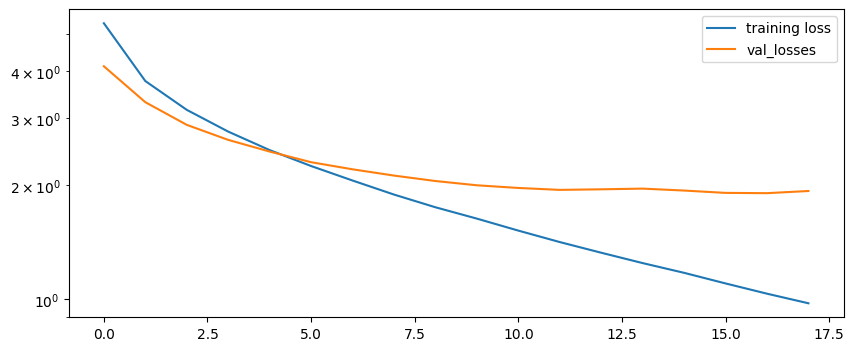

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10,4))
axes.plot(train_losses, label='training loss')
axes.plot(val_losses, label='val_losses')
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
print(translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu ."))

 A group of people stand in front of an igloo . 


In [ ]:
# torch.cuda.set_device(0) # which GPU to use
torch.cuda.empty_cache()

References
==========

1.  Attention is all you need paper.
    <https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf>
2.  The annotated transformer.
    <https://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding>
